#Mounting Google Drive in Google Colab


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Accessing and Extracting Data from a ZIP Archive

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jayaprakashpondy/ecgimages

Dataset URL: https://www.kaggle.com/datasets/jayaprakashpondy/ecgimages
License(s): unknown
100% 286M/286M [00:15<00:00, 20.5MB/s]
100% 286M/286M [00:15<00:00, 19.0MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile("/content/ecgimages.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

#Edit Image shape

In [ ]:
image_size = 224
target_size = (image_size, image_size)
input_shape =(image_size,image_size,3)
grid_shape = (1,image_size,image_size,3)
batch_size = 32

#Importing tensorflow module

In [ ]:
import tensorflow as tf

#Image augmentation and data loading

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_data = train_datagen.flow_from_directory(
    '/content/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data= test_datagen.flow_from_directory(
    '/content/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Disable shuffling for test data
)


Found 928 images belonging to 4 classes.
Found 448 images belonging to 4 classes.


#Importing module from tensorflow keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#Transfer learning with custom layers

In [ ]:
# Load the MobileNet model with pre-trained weights, excluding the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model's layers (to retain pre-trained features)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(train_data.num_classes, activation='softmax')(x)  # Final layer for classification

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Save model and stop early

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_mobilenet_model.keras', monitor='val_accuracy', save_best_only=True)

#Train model with validation monitoring

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25,  # You can adjust the number of epochs
    batch_size=batch_size,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2707 - loss: 2.3634 - val_accuracy: 0.2522 - val_loss: 1.5634
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2891 - loss: 1.4338 - val_accuracy: 0.3192 - val_loss: 1.4450
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3843 - loss: 1.3089 - val_accuracy: 0.2500 - val_loss: 2.0027
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3380 - loss: 1.3318 - val_accuracy: 0.3125 - val_loss: 1.4822
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3618 - loss: 1.3411 - val_accuracy: 0.2500 - val_loss: 1.9002
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3891 - loss: 1.3046 - val_accuracy: 0.2902 - val_loss: 1.5153
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3850 - loss: 1.2795 - val_accuracy: 0.2500 - val_loss: 1.9048


#Save final model

In [ ]:
model.save('mymobilenet_final_model.keras')


#Evaluate model on test data

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 662ms/step - accuracy: 0.1499 - loss: 1.7178
Test Loss: 1.4449585676193237
Test Accuracy: 0.3191964328289032


#Visualizing training and validation performance.


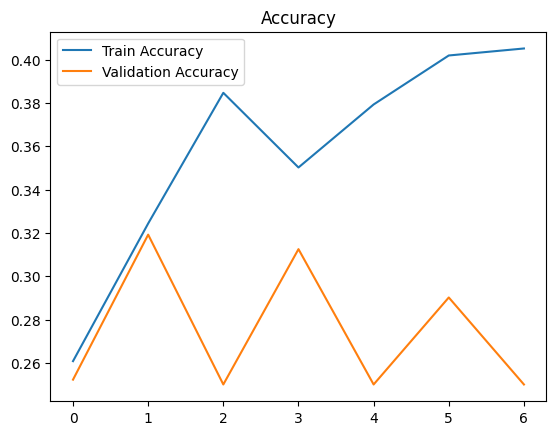

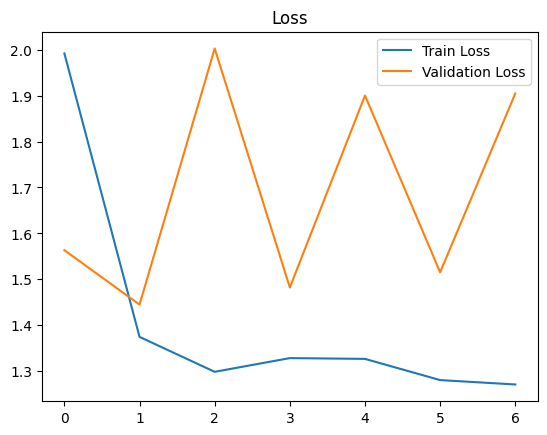

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()
